In [2]:
#!pip install dask-ml
#import dask.dataframe as dd  
#from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd  
import numpy as np
import boto3
import tempfile
import os
import random

In [3]:
#Load some data
s3 = boto3.resource('s3', region_name='us-east-1')
bucket = s3.Bucket('song-feature-csvs')

fname = 'final_dataset.csv'
if os.path.isfile(fname) == False:
    %sc
    !wget 'https://song-feature-csvs.s3.amazonaws.com/final_dataset.csv'

#result = dd.read_csv(fname)
#result_categorical = list(result.select_dtypes(include=['O']).columns)
#result_numerical = list(result.select_dtypes(include=[np.number]).columns)

#result_target = 'genre'
#result_categorical.remove(result_target)

#verify no categoricals left 
#should be an empty list
#result_categorical

In [4]:
n = sum(1 for line in open('final_dataset.csv')) - 1 #number of records in file
s = 1000
skip = sorted(random.sample(range(1,n+1),n-s))

sample = pd.read_csv('final_dataset.csv', skiprows=skip)
sample = sample.drop(['Unnamed: 0', 'track_id', 'artist_id', 'track_comments', 'track_disc_number', 'track_favorites', 
             'track_instrumental', 'track_interest', 'track_listens', 'track_number'], axis=1)

In [5]:
sample_target = 'genre'

In [7]:
sample["genre"].unique()

array(['Pop'], dtype=object)

In [84]:
sample_numerical = list(sample.loc[:, sample.columns != sample_target].columns)

In [85]:
scaler = StandardScaler()

# split into input (X) and output (Y) variables
sample_df = pd.DataFrame(sample[sample_numerical])
X = sample[sample_numerical]
X = X.astype('float')
#X = StandardScaler().fit_transform(X)

Y = sample[sample_target]
input_dim = X.shape[1]

In [86]:
X = X.drop(X.columns[X.isna().any()].tolist(), axis = 1)

In [87]:
input_dim

8088

Feature ranking:
rhythm_beats_position_536: 0.0
lowlevel_melbands_mean_14: 0.0
lowlevel_melbands_mean_7: 0.0
lowlevel_melbands_mean_8: 0.0
lowlevel_melbands_mean_9: 0.0
lowlevel_melbands_mean_10: 0.0
lowlevel_melbands_mean_11: 0.0
lowlevel_melbands_mean_12: 0.0
lowlevel_melbands_mean_13: 0.0
lowlevel_melbands_mean_15: 0.0
lowlevel_melbands_max_26: 0.0
lowlevel_melbands_mean_16: 0.0
lowlevel_melbands_mean_17: 0.0
lowlevel_melbands_mean_18: 0.0
lowlevel_melbands_mean_19: 0.0
lowlevel_melbands_mean_20: 0.0
lowlevel_melbands_mean_21: 0.0
lowlevel_melbands_mean_22: 0.0
lowlevel_melbands_mean_6: 0.0
lowlevel_melbands_mean_5: 0.0
lowlevel_melbands_mean_4: 0.0
lowlevel_melbands_mean_3: 0.0
lowlevel_melbands_max_28: 0.0
lowlevel_melbands_max_29: 0.0
lowlevel_melbands_max_30: 0.0
lowlevel_melbands_max_31: 0.0
lowlevel_melbands_max_32: 0.0
lowlevel_melbands_max_33: 0.0
lowlevel_melbands_max_34: 0.0
lowlevel_melbands_max_35: 0.0
lowlevel_melbands_max_36: 0.0
lowlevel_melbands_max_37: 0.0
lowlevel_

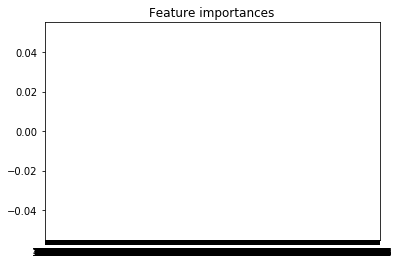

In [88]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    index = indices[f]
    #print(index)
    print(sample_df.iloc[:,[index]].columns[0] + ': ' + str(importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [89]:
import tensorflow.keras as keras 
from keras.constraints import maxnorm
from keras.layers import Dropout
import dask.array as da
#from dask_ml.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import fbeta_score, make_scorer
f1_scorer = make_scorer(fbeta_score, beta=1)

# Function to create model, required for KerasClassifier
def create_model(
    activation='relu',
    dropout_rate=0.0,
    init_mode='uniform',
    weight_constraint=0,
    optimizer='adam',
    neurons = 1,
    lr=0.01,
    momentum=0):
    
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, kernel_initializer=init_mode,
                    activation=activation, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7

#Split the data for classification
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=.25, shuffle=False)

# create model
model = KerasClassifier(build_fn=create_model, batch_size=1000, epochs=10)

#gridsearch
activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
dropout_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
weight_constraint = [1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

epochs = [1, 10, 50, 100]
batch_size = [1000, 5000]
param_grid = dict(epochs=epochs, 
                  batch_size=batch_size, 
                  activation=activation, 
                  momentum=momentum, 
                  dropout_rate = dropout_rate, 
                  weight_constraint = weight_constraint, 
                  neurons = neurons, 
                  init_mode = init_mode, 
                  optimizer = optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=3, scoring=f1_scorer)
grid_result = grid.fit(train_x, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

OSError: [Errno 12] Cannot allocate memory